**Subscribe** to this channel and **follow** *@dsbyhadi* on twitter for updates!

*email: datasciencebyhadi@gmail.com*

----

### Sentiment analysis via Embedding and BOW, real scale.
#### Tool: fastText and sklearn

In [3]:
import fastText #version 0.8.22
import pandas as pd
import os
from fastText import train_supervised
import numpy as np

In [4]:
# To show the output of all lines in a cell rather that just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

`The architecture of fasttext supervised learning is like word2vec CBOW where the target word is replaced with the label.`

In [5]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [6]:
DATA_DIR = "~/Downloads/ft_amazon/"

Source: 
- https://www.kaggle.com/bittlingmayer/amazonreviews#train.ft.txt.bz2
- https://www.kaggle.com/bittlingmayer/amazonreviews#test.ft.txt.bz2

In [16]:
train_data = pd.read_table(DATA_DIR+"train.ft.txt", header=None, names=['sentence'])
train_data.shape

(3600000, 1)

In [6]:
train_data.head(10)

,sentence
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."
5,__label__2 an absolute masterpiece: I am quite...
6,__label__1 Buyer beware: This is a self-publis...
7,__label__2 Glorious story: I loved Whisper of ...
8,__label__2 A FIVE STAR BOOK: I just finished r...
9,__label__2 Whispers of the Wicked Saints: This...


`__label__1` is negative sentiment and `__label__2` is positive sentiment

In [7]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['sentence'])
test_data.shape

(400000, 1)

train_data is too large for our case. So I'm going to use test_data only.

In [45]:
import re

def normalize(row):
    lower = row['sentence'].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    text = no_mult_ws.strip()
    return text

In [46]:
test_data['normalized_sentence'] = test_data.apply(normalize, axis=1)

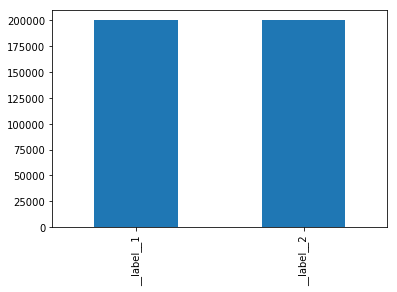

In [47]:
test_data['label'] = test_data['normalized_sentence'].apply(lambda row: row[0:10])
test_data['just_sentence'] = test_data['normalized_sentence'].apply(lambda row: row[10:])
test_data.drop(['sentence', 'normalized_sentence'], axis=1, inplace=True)
%matplotlib inline
test_data['label'].value_counts().plot(kind='bar')

In [48]:
test_data.head(3)

,label,just_sentence
0,__label__2,great cd: my lovely pat has one of the great ...
1,__label__2,one of the best game music soundtracks - for ...
2,__label__1,batteries died within a year ...: i bought th...


In [49]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [50]:
dummy_train_data.shape
dummy_test_data.shape

(260000, 2)

(140000, 2)

In [51]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.test'), header=False, index=False, sep='\t')

In [52]:
train_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon.train'#os.path.join(DATA_DIR, 'ft_amazon.train')
test_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon.test' #os.path.join(DATA_DIR, 'ft_amazon.test')

%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))
amazon_sentiment_model.save_model("amazon_sentiment_model.bin")

CPU times: user 8min 11s, sys: 2.84 s, total: 8min 13s
Wall time: 1min 19s
On train
N	260000
P@1	0.904
R@1	0.904
On test
N	140000
P@1	0.897
R@1	0.897


In [63]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ova", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 22min 33s, sys: 3.9 s, total: 22min 37s
Wall time: 3min 22s
On train
N	260000
P@1	0.916
R@1	0.916
On test
N	140000
P@1	0.901
R@1	0.901


Trying transfer learning

In [13]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.1, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 38s, sys: 8.93 s, total: 5min 47s
Wall time: 4min 24s
On train
N	260000
P@1	0.910
R@1	0.910
On test
N	140000
P@1	0.894
R@1	0.894


In [14]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 34s, sys: 8.32 s, total: 5min 42s
Wall time: 4min 20s
On train
N	260000
P@1	0.909
R@1	0.909
On test
N	140000
P@1	0.893
R@1	0.893


In [25]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=5, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 8min 7s, sys: 7.35 s, total: 8min 14s
Wall time: 4min 41s
On train
N	260000
P@1	0.925
R@1	0.925
On test
N	140000
P@1	0.896
R@1	0.896


Looks like more epochs is now causing overfitting..

In [23]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, minn=3, maxn=4, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 17min 9s, sys: 15.2 s, total: 17min 25s
Wall time: 6min 16s
On train
N	260000
P@1	0.905
R@1	0.905
On test
N	140000
P@1	0.897
R@1	0.897


### Experimenting with removing punctuations

In [8]:
import re
import string

def normalize(row, col_name):
    lower = row[col_name].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    striped = no_mult_ws.strip()
    #remove punctuations
    no_punc = striped.translate(str.maketrans('', '', string.punctuation))
    return no_punc

In [9]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['label_sentence'])

test_data['label'] = test_data['label_sentence'].apply(lambda row: row[0:10])
test_data['sentence'] = test_data['label_sentence'].apply(lambda row: row[10:])
test_data['normalized_sentence'] = test_data.apply(lambda row: normalize(row, 'sentence'), axis=1)

test_data.drop(['label_sentence', 'sentence'], axis=1, inplace=True)

In [10]:
test_data.head(3)

,label,normalized_sentence
0,__label__2,great cd my lovely pat has one of the great vo...
1,__label__2,one of the best game music soundtracks for a ...
2,__label__1,batteries died within a year i bought this ch...


In [40]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [41]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.test'), header=False, index=False, sep='\t')

In [42]:
train_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon_punc.train'
test_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon_punc.test'

%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 8min 4s, sys: 4.11 s, total: 8min 8s
Wall time: 1min 18s
On train
N	260000
P@1	0.900
R@1	0.900
On test
N	140000
P@1	0.894
R@1	0.894


In [43]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 20min 50s, sys: 7.87 s, total: 20min 58s
Wall time: 3min 22s
On train
N	260000
P@1	0.907
R@1	0.907
On test
N	140000
P@1	0.898
R@1	0.898


Needs further grid_search ...

### Experimenting with BOW

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [19]:
text_classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=None, ngram_range=(1, 2), max_features=50000, binary=False)),
    ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
    ('clf', LogisticRegression(penalty='l1', C=0.9, random_state=21)),
])

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     test_data.normalized_sentence, test_data.label, test_size=0.35, random_state=4)

In [21]:
%time text_classifier.fit(X_train, y_train) 

CPU times: user 1min 27s, sys: 3.31 s, total: 1min 30s
Wall time: 1min 30s


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
      ...alty='l1', random_state=21, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [22]:
from sklearn import metrics

predicted_train = text_classifier.predict(X_train)

y_train = y_train.astype('category')
print(metrics.classification_report(y_train, predicted_train,
    labels=y_train.cat.categories.tolist()))

metrics.confusion_matrix(y_train, predicted_train)

predicted_test = text_classifier.predict(X_test)

y_test = y_test.astype('category')
print(metrics.classification_report(y_test, predicted_test,
    labels=y_test.cat.categories.tolist()))

metrics.confusion_matrix(y_test, predicted_test)

             precision    recall  f1-score   support

 __label__1       0.93      0.93      0.93    130114
 __label__2       0.93      0.93      0.93    129886

avg / total       0.93      0.93      0.93    260000



array([[120980,   9134],
       [  8752, 121134]])

             precision    recall  f1-score   support

 __label__1       0.92      0.92      0.92     69886
 __label__2       0.92      0.92      0.92     70114

avg / total       0.92      0.92      0.92    140000



array([[64220,  5666],
       [ 5310, 64804]])